## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install necessary libraries

In [3]:
import os

# Path to the dataset in Google Drive
DATASET_PATH = "/content/drive/MyDrive/helmet_dataset"

# Check if the folder exists
if os.path.exists(DATASET_PATH):
    print("Dataset found ✅")
else:
    print("Dataset not found ❌. Check your Google Drive path!")

Dataset found ✅


In [4]:
!pip install torch torchvision pandas xmltodict matplotlib imagehash

In [26]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
import xml.etree.ElementTree as ET
import xmltodict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import os
import imagehash
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.cuda.amp import autocast, GradScaler
import time

##   Load & parse annotations (XML to CSV)

In [6]:
ANNOTATIONS_DIR = os.path.join(DATASET_PATH, "annotations")
IMAGES_DIR = os.path.join(DATASET_PATH, "images")

def parse_voc_xml(xml_file):
    with open(xml_file) as f:
        data = xmltodict.parse(f.read())

    filename = data["annotation"]["filename"]
    objects = []

    for obj in data["annotation"].get("object", []):
        if isinstance(obj, dict):  # Handle multiple objects
            name = obj["name"]
            bbox = obj["bndbox"]
            xmin, ymin, xmax, ymax = int(bbox["xmin"]), int(bbox["ymin"]), int(bbox["xmax"]), int(bbox["ymax"])
            objects.append([filename, name, xmin, ymin, xmax, ymax])

    return objects

# Process all XML files
data = []
for xml_file in os.listdir(ANNOTATIONS_DIR):
    if xml_file.endswith(".xml"):
        data.extend(parse_voc_xml(os.path.join(ANNOTATIONS_DIR, xml_file)))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["filename", "class", "xmin", "ymin", "xmax", "ymax"])

# Save to CSV
csv_path = os.path.join(DATASET_PATH, "helmet_annotations.csv")
df.to_csv(csv_path, index=False)

print(f"Annotations converted and saved to {csv_path}")

Annotations converted and saved to /content/drive/MyDrive/helmet_dataset/helmet_annotations.csv


## Perform Exploratory Data Analysis (EDA)

In [7]:
csv_path = "/content/drive/MyDrive/helmet_dataset/helmet_annotations.csv"
IMAGES_DIR = "/content/drive/MyDrive/helmet_dataset/images"

df = pd.read_csv(csv_path)

# Check if images are in train or val folders
def correct_path(filename):
    if os.path.exists(os.path.join(IMAGES_DIR, "train", filename)):
        return f"train/{filename}"
    elif os.path.exists(os.path.join(IMAGES_DIR, "val", filename)):
        return f"val/{filename}"
    else:
        return filename  # Keep original if not found

df["filename"] = df["filename"].apply(correct_path)

# Save updated CSV
df.to_csv(csv_path, index=False)
print("✅ Updated CSV saved with correct image paths.")

✅ Updated CSV saved with correct image paths.


In [8]:
missing_files = []
for img_name in df["filename"]:
    img_path = os.path.join(IMAGES_DIR, img_name)
    if not os.path.exists(img_path):
        missing_files.append(img_path)

print(f"Missing images after path update: {len(missing_files)}")
print(missing_files[:5])  # Print first 5 missing files

Missing images after path update: 0
[]


In [9]:
# ✅ 1. Check dataset overview
print("\n📌 Dataset Overview:")
print(df.head())
print(df.info())


📌 Dataset Overview:
                         filename   class  xmin  ymin  xmax  ymax
0  train/hard_hat_workers2896.png  helmet   283   120   343   191
1  train/hard_hat_workers2896.png  helmet   128   128   182   197
2  train/hard_hat_workers2896.png  helmet   204   141   258   213
3  train/hard_hat_workers2896.png  helmet   256   131   311   200
4  train/hard_hat_workers2896.png  helmet   283     0   344    19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24807 entries, 0 to 24806
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  24807 non-null  object
 1   class     24807 non-null  object
 2   xmin      24807 non-null  int64 
 3   ymin      24807 non-null  int64 
 4   xmax      24807 non-null  int64 
 5   ymax      24807 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.1+ MB
None


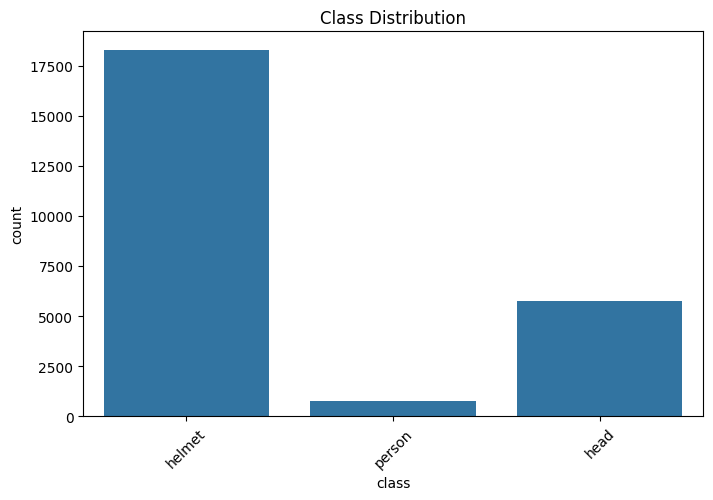

In [10]:
# ✅ 2. Check class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=df['class'])
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

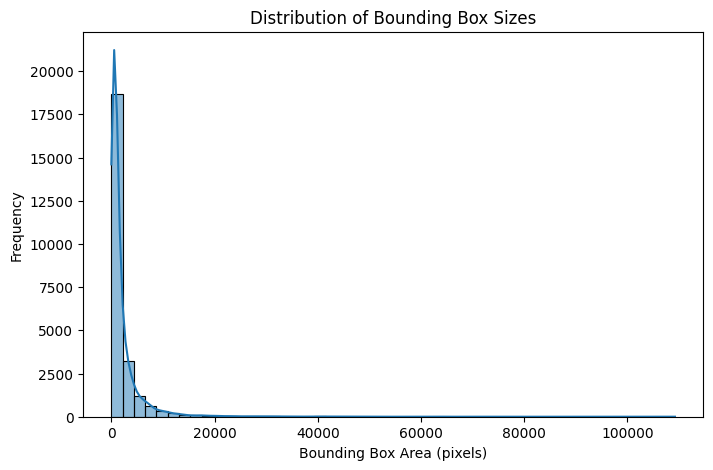

In [11]:
df["bbox_area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

plt.figure(figsize=(8, 5))
sns.histplot(df["bbox_area"], bins=50, kde=True)
plt.xlabel("Bounding Box Area (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Sizes")
plt.show()

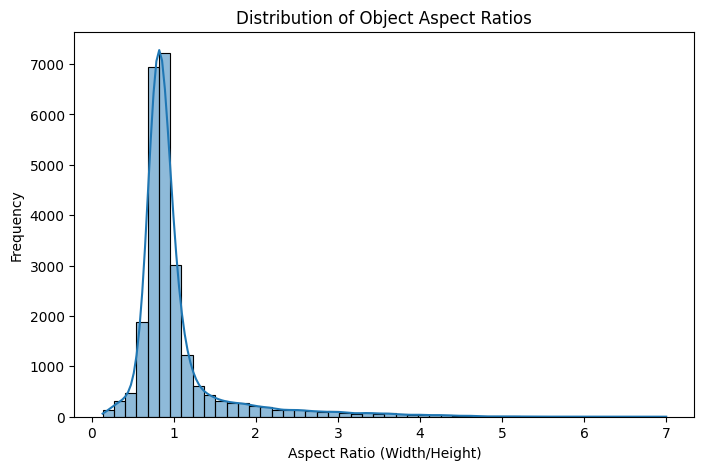

In [12]:
df["aspect_ratio"] = (df["xmax"] - df["xmin"]) / (df["ymax"] - df["ymin"])

plt.figure(figsize=(8, 5))
sns.histplot(df["aspect_ratio"], bins=50, kde=True)
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Distribution of Object Aspect Ratios")
plt.show()

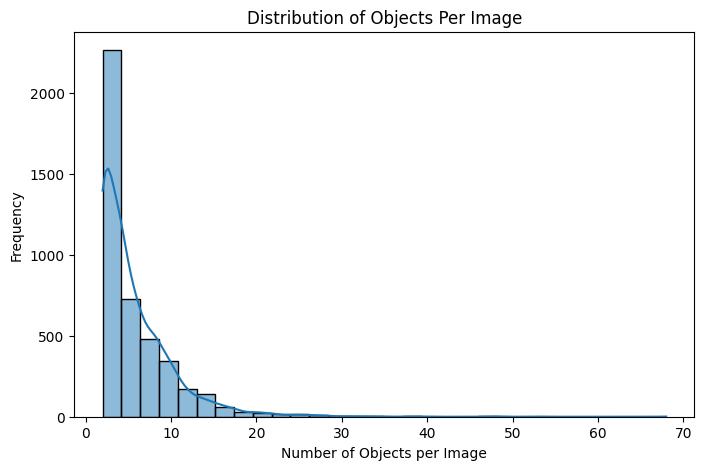

In [13]:
object_counts = df["filename"].value_counts()

plt.figure(figsize=(8, 5))
sns.histplot(object_counts, bins=30, kde=True)
plt.xlabel("Number of Objects per Image")
plt.ylabel("Frequency")
plt.title("Distribution of Objects Per Image")
plt.show()

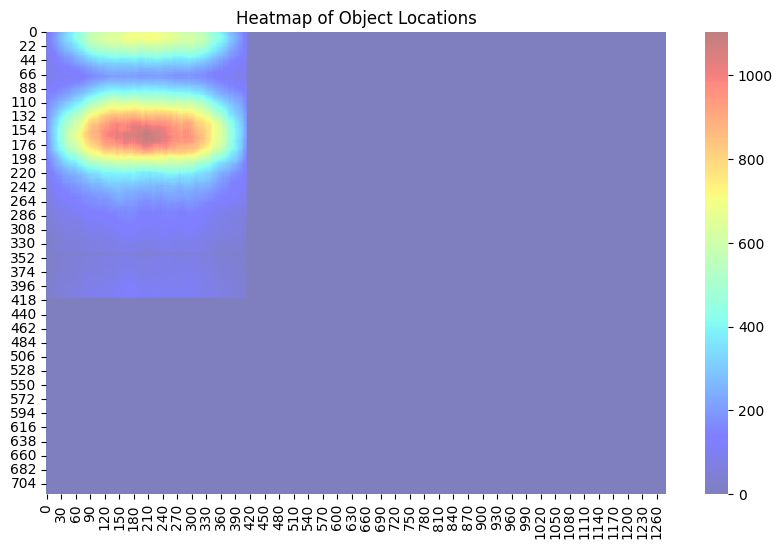

In [14]:
heatmap = np.zeros((720, 1280))  # Assuming typical image size (change if needed)

for _, row in df.iterrows():
    x1, y1, x2, y2 = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    heatmap[y1:y2, x1:x2] += 1

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap, cmap="jet", alpha=0.5)
plt.title("Heatmap of Object Locations")
plt.show()

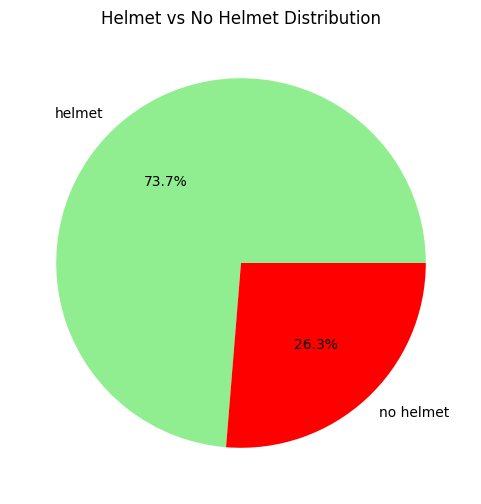

In [15]:
helmet_vs_nohelmet = df["class"].apply(lambda x: "helmet" if "helmet" in x else "no helmet")

plt.figure(figsize=(6, 6))
helmet_vs_nohelmet.value_counts().plot.pie(autopct="%1.1f%%", colors=["lightgreen", "red"])
plt.title("Helmet vs No Helmet Distribution")
plt.ylabel("")
plt.show()

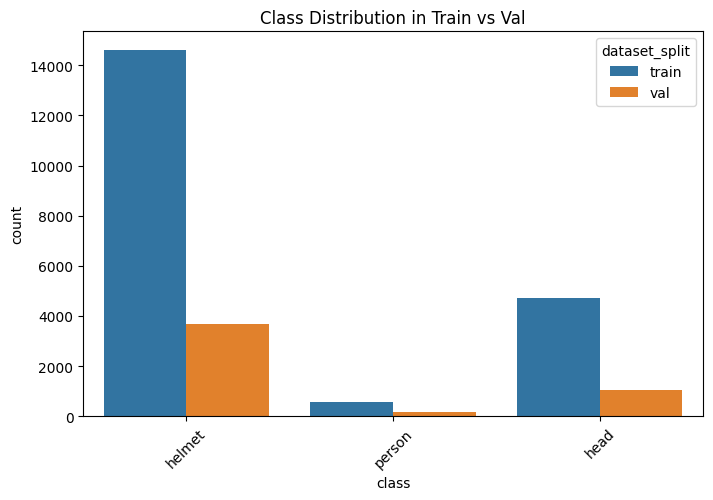

In [16]:
df["dataset_split"] = df["filename"].apply(lambda x: "train" if "train" in x else "val")

plt.figure(figsize=(8, 5))
sns.countplot(x=df["class"], hue=df["dataset_split"])
plt.title("Class Distribution in Train vs Val")
plt.xticks(rotation=45)
plt.show()

In [17]:
class HelmetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_mapping = {"helmet": 0, "head": 1, "person": 2}  # Multi-class mapping

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # Uses train/ or val/ prefix

        # Handle missing/corrupt images
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError):
            print(f"Warning: Missing or unreadable image {img_path}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))  # Return blank image

        # Convert class label to integer
        label_str = self.img_labels.iloc[idx, 1]
        label = self.class_mapping.get(label_str, -1)  # -1 if class not found

        if self.transform:
            image = self.transform(image)

        return image, label

In [19]:
transform = transforms.Compose([
    # 1. Resize while keeping aspect ratio (Avoids distortion)
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),  # Crop to 224x224 for ConvNeXt

    # 2. Augmentations for robustness
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(degrees=10),  # Rotate slightly
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust lighting

    # 3. Convert to Tensor
    transforms.ToTensor(),

    # 4. Apply ImageNet normalization (Recommended for ConvNeXt)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
# Define separate transforms for train and test
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    ], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
# Load dataset labels
df = pd.read_csv(csv_path)

# Split into train (80%) and test (20%) while maintaining class distribution
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)

# Save new CSVs for train/val split
train_csv_path = os.path.join(DATASET_PATH, "train_annotations.csv")
test_csv_path = os.path.join(DATASET_PATH, "test_annotations.csv")

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"✅ Train & Test CSVs saved: {len(train_df)} train, {len(test_df)} test images")

✅ Train & Test CSVs saved: 19845 train, 4962 test images


In [23]:
# Load train dataset
train_dataset = HelmetDataset(train_csv_path, IMAGES_DIR, transform=train_transform)
test_dataset = HelmetDataset(test_csv_path, IMAGES_DIR, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Dataset Loaded: {len(train_dataset)} train images, {len(test_dataset)} test images")

✅ Dataset Loaded: 19845 train images, 4962 test images


In [24]:
# Load pre-trained ConvNeXt model
model = torchvision.models.convnext_tiny(pretrained=True)

# Get the number of input features for the classifier
num_ftrs = model.classifier[-1].in_features

# Modify the final classification layer for 3 classes (helmet, head, person)
num_classes = 3  # Update based on your dataset
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✅ ConvNeXt model loaded and modified for {num_classes} classes")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 200MB/s] 


✅ ConvNeXt model loaded and modified for 3 classes


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [41]:
# Training function with validation, mixed precision, and best model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)  # Move model to GPU if available
    best_val_acc = 0.0  # Track the best validation accuracy
    scaler = GradScaler()  # Remove device_type argument from GradScaler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()  # Ensure labels are LongTensor

            optimizer.zero_grad()  # Clear gradients
            with autocast(enabled=True):  # Remove device_type argument
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

            scaler.scale(loss).backward()  # Backpropagation
            scaler.step(optimizer)  # Update weights
            scaler.update()  # Update scaler for mixed precision

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        end_time = time.time()
        scheduler.step()  # Adjust learning rate

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {end_time-start_time:.2f}s")

        # Validate after each epoch
        val_acc = evaluate_model(model, val_loader, criterion, device)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved!")

    print("Training complete ✅")

# ✅ 3. Define Validation Function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f"✅ Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    return val_acc


In [42]:
# Train model with validation set
train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10)

<ipython-input-41-e67122b50705>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Remove device_type argument from GradScaler
<ipython-input-41-e67122b50705>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):  # Remove device_type argument


Epoch [1/10] - Loss: 0.2799, Accuracy: 90.63%, Time: 566.30s
✅ Validation - Loss: 0.2280, Accuracy: 91.11%
✅ Best model saved!
Epoch [2/10] - Loss: 0.2140, Accuracy: 91.38%, Time: 175.14s
✅ Validation - Loss: 0.2126, Accuracy: 90.99%
Epoch [3/10] - Loss: 0.1902, Accuracy: 91.51%, Time: 174.28s
✅ Validation - Loss: 0.2039, Accuracy: 90.69%
Epoch [4/10] - Loss: 0.1783, Accuracy: 91.38%, Time: 174.90s
✅ Validation - Loss: 0.1939, Accuracy: 90.73%
Epoch [5/10] - Loss: 0.1699, Accuracy: 91.61%, Time: 173.74s
✅ Validation - Loss: 0.2040, Accuracy: 90.97%
Epoch [6/10] - Loss: 0.1562, Accuracy: 92.23%, Time: 174.11s
✅ Validation - Loss: 0.2024, Accuracy: 91.17%
✅ Best model saved!
Epoch [7/10] - Loss: 0.1516, Accuracy: 92.11%, Time: 174.18s
✅ Validation - Loss: 0.2168, Accuracy: 90.81%
Epoch [8/10] - Loss: 0.1533, Accuracy: 92.12%, Time: 174.09s
✅ Validation - Loss: 0.2050, Accuracy: 90.97%
Epoch [9/10] - Loss: 0.1520, Accuracy: 92.10%, Time: 174.31s
✅ Validation - Loss: 0.2106, Accuracy: 90.5

In [43]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set to evaluation mode
print("✅ Best model loaded!")

✅ Best model loaded!


<ipython-input-43-e1c5abbf52be>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


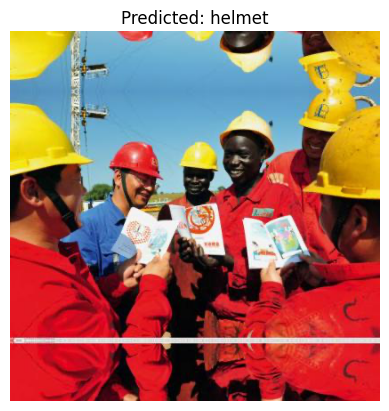

In [46]:
# Load a random image from the test set
sample_idx = 0  # Change this index to test different images
image_path = os.path.join(IMAGES_DIR, test_dataset.img_labels.iloc[sample_idx, 0])

# Load and transform the image
image = Image.open(image_path).convert("RGB")
input_tensor = val_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Predict
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, 1).item()

# Get class labels
class_mapping = {0: "helmet", 1: "head", 2: "person"}
predicted_label = class_mapping[predicted_class]

# Display the image with prediction
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

In [47]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"📊 Final Test Accuracy: {test_accuracy:.2f}%")

📊 Final Test Accuracy: 91.17%


In [48]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_mapping.values()))

              precision    recall  f1-score   support

      helmet       0.94      0.94      0.94      3658
        head       0.88      0.88      0.88      1154
      person       0.46      0.53      0.49       150

    accuracy                           0.91      4962
   macro avg       0.76      0.78      0.77      4962
weighted avg       0.91      0.91      0.91      4962



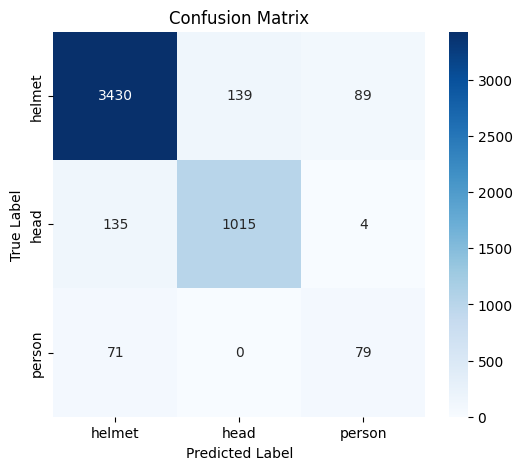

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_mapping.values(), yticklabels=class_mapping.values())

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [50]:
# Convert model to TorchScript for deployment
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224).to(device))
torch.jit.save(traced_model, "convnext_helmet_model.pt")
print("✅ Model saved for inference!")

✅ Model saved for inference!
